<a href="https://colab.research.google.com/github/DEKDEGUE-Hajar/Intelligent-SIEM-Security-Information-and-Event-Management-/blob/main/Attack_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TriBoost Model

## Import libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install callable
!pip install scikit-multilearn
!pip install imblearn
!pip install lightgbm
!pip install catboost
!pip install xgboost
!pip install river
!pip install lightgbm
!pip install catboost
!pip install xgboost
!pip install river

  Preparing metadata (setup.py) ... done
  Created wheel for callable: filename=callable-0.1.2-py3-none-any.whl size=3150 sha256=19860938b7a25f9fc1c3f8b371ae74f2123908e178efc5acab5679f3d475b828
  Stored in directory: /root/.cache/pip/wheels/da/80/96/8408fddab74ebf7529a673ac029385043d4529e8581160a877
Successfully built callable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Succes

In [ ]:
#mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

## Read the Preprocesssed CICIDS2017 dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SIEM_project/Pre_Processed_CICIDS2017")

In [ ]:
df.head()

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,Attack Number
0,0,-2.413279,-0.072254,0.540243,-0.221672,0.305700,5.074363,-0.087184,0.458903,0.769866,...,-1.476949,0.201064,1.612777,-0.087501,-0.030564,-0.101496,-0.011824,0.037173,-0.036353,0
1,1,-3.117696,-0.102330,0.946275,-0.441500,0.568614,14.855107,-0.334696,1.835610,4.746431,...,-1.225075,0.802697,2.573639,-0.150756,0.195665,0.138007,-0.034688,0.109619,-0.256890,0
2,2,-2.491644,-0.075671,0.585797,-0.246672,0.333756,6.161294,-0.114832,0.610379,1.212816,...,-1.446557,0.266580,1.721182,-0.094624,-0.006166,-0.074982,-0.014389,0.044941,-0.060651,0
3,3,-3.117792,-0.102406,0.946715,-0.442075,0.567457,14.855289,-0.334843,1.834119,4.747541,...,-1.222669,0.801364,2.575282,-0.150851,0.194926,0.137909,-0.034712,0.109338,-0.256684,0
4,4,-1.672399,0.087287,-0.485631,0.484069,0.800230,-0.086504,0.105581,0.854430,-1.123756,...,0.605173,-0.599781,0.950659,-0.056666,-0.167681,0.281508,-0.032918,-0.080418,0.010373,0


In [ ]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
df["Attack Number"].value_counts()

,count
Attack Number,
0,1897862
4,193748
3,128016
2,9152
8,2143
7,1958
1,1441
6,36
5,11


## SMOTE to solve class-imbalance

In [ ]:
class_counts = df['Attack Number'].value_counts()
selected_classes = class_counts[class_counts > 1400]
class_names = selected_classes.index
selected = df[df['Attack Number'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Number'] == name]
  if len(df) > 10000:
    df = df.sample(n = 12000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Number'].value_counts()

,count
Attack Number,
0,12000
4,12000
3,12000
2,9152
8,2143
7,1958
1,1441


In [ ]:
# Reassign labels to continuous range using pd.factorize
df['Attack Number'], label_mapping = pd.factorize(df['Attack Number'])

# Print the new class distribution
print(df['Attack Number'].value_counts())

# Optionally, print the original-to-new label mapping
label_mapping = dict(enumerate(label_mapping))
print('Original to New Label Mapping:')
print(label_mapping)


Attack Number
0    12000
1    12000
2    12000
3     9152
4     2143
5     1958
6     1441
Name: count, dtype: int64
Original to New Label Mapping:
{0: 0, 1: 4, 2: 3, 3: 2, 4: 8, 5: 7, 6: 1}


In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Number', axis=1)
y = df['Attack Number']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Number'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Number'].value_counts()

,count
Attack Number,
3,12000
2,12000
5,12000
0,12000
4,12000
1,12000
6,12000


## Split train set and test set

In [ ]:
features = blnc_data.drop('Attack Number', axis = 1)
labels = blnc_data['Attack Number']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, stratify=labels, random_state = 0)

In [ ]:
pd.Series(y_train).value_counts()

,count
Attack Number,
6,9000
4,9000
5,9000
2,9000
3,9000
1,9000
0,9000


## Machine Learning (ML) model training
### Training three base learners: LightGBM, XGBoost, CatBoost

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 63000, number of used features: 34
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3000
           1       1.00      0.99      0.99      3000
           2       1.00      1.00      1.00      3000
           3       0.99      0.99      0.99      300

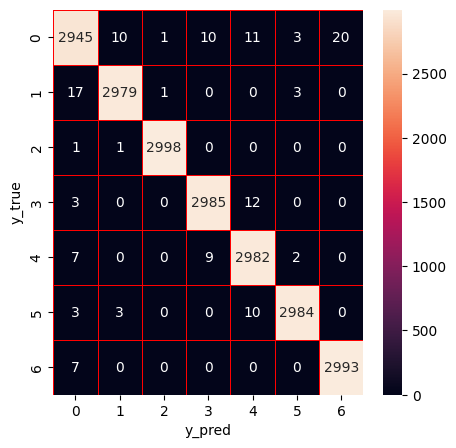

CPU times: user 16 s, sys: 121 ms, total: 16.1 s
Wall time: 25.2 s


In [ ]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3000
           1       1.00      0.99      0.99      3000
           2       1.00      1.00      1.00      3000
           3       1.00      1.00      1.00      3000
           4       0.99      0.99      0.99      3000
           5       1.00      1.00      1.00      3000
           6       0.99      1.00      1.00      3000

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000

Accuracy of XGBoost: 0.9940952380952381
Precision of XGBoost: 0.9940943023002335
Recall of XGBoost: 0.9940952380952381
Average F1 of XGBoost: 0.9940918759278833
F1 of XGBoost for each type of attack: [0.9852892  0.99465955 0.99933333 0.99600133 0.99201597 0.99633211
 0.99501164]


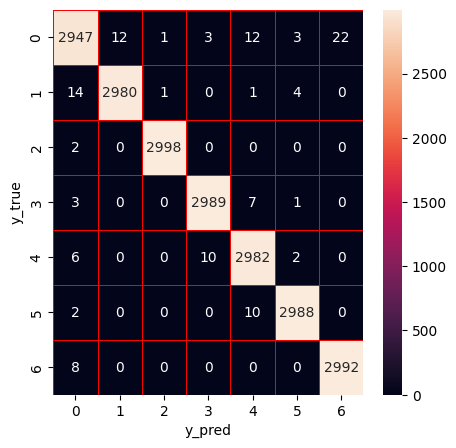

CPU times: user 16.3 s, sys: 127 ms, total: 16.4 s
Wall time: 8.59 s


In [ ]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3000
           1       1.00      0.99      0.99      3000
           2       1.00      1.00      1.00      3000
           3       1.00      1.00      1.00      3000
           4       0.99      1.00      1.00      3000
           5       1.00      1.00      1.00      3000
           6       0.99      1.00      1.00      3000

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000

Accuracy of Random Forest: 0.9953333333333333
Precision of Random Forest: 0.995334958165421
Recall of Random Forest: 0.9953333333333333
Average F1 of Random Forest: 0.995332181311614
F1 of Random Forest for each type of attack: [0.98781912 0.99499332 0.99916597 0.99667    0.99600533 0.99666222
 0.99600931]


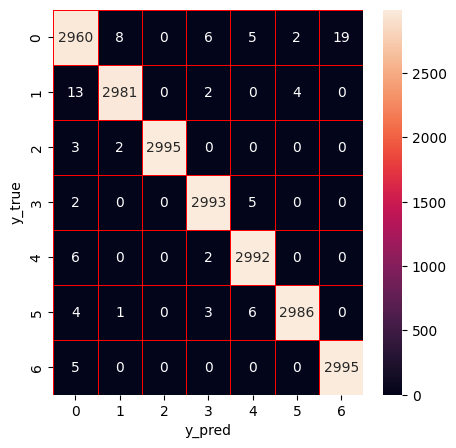

CPU times: user 49.1 s, sys: 118 ms, total: 49.2 s
Wall time: 50.3 s


In [ ]:
%%time
# Train the Random Forest algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy of Random Forest: " + str(accuracy_score(y_test, y_pred)))
print("Precision of Random Forest: " + str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of Random Forest: " + str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of Random Forest: " + str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Random Forest for each type of attack: " + str(f1_score(y_test, y_pred, average=None)))

# Store F1 scores for further use
rf_f1 = f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3000
           1       0.99      0.99      0.99      3000
           2       1.00      1.00      1.00      3000
           3       0.99      0.99      0.99      3000
           4       0.98      0.99      0.99      3000
           5       1.00      0.99      0.99      3000
           6       0.99      1.00      0.99      3000

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000

Accuracy of CatBoost: 0.9921428571428571
Precision of CatBoost: 0.9921510822172062
Recall of CatBoost: 0.9921428571428571
Average F1 of CatBoost: 0.9921389211530411
F1 of CatBoost for each type of attack: [0.98076601 0.99282257 0.99950008 0.995      0.9892152  0.99381374
 0.99385484]


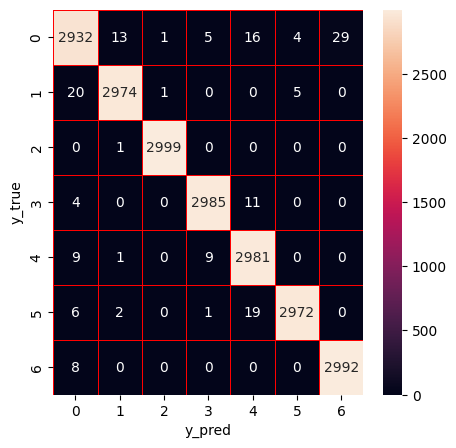

CPU times: user 3min 21s, sys: 1.52 s, total: 3min 23s
Wall time: 2min 6s


In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Proposed ensemble model: Leader Class and Confidence Decision Ensemble (LCCDE)

LCCDE aims to achieve optimal model performance by identifying the best-performing base ML model with the highest prediction confidence for each class.

### Find the best-performing (leading) model for each type of attack among the three ML models

In [ ]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)

In [ ]:
model

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               ena

In [ ]:
# Dictionnaire des classes d'attaque
attack_classes = {
    0: "BENIGN",
    1: "Bot",
    2: "Brute Force",
    3: "DDoS",
    4: "DoS",
    5: "Heartbleed",
    6: "Infiltration"
}

# Dictionnaire pour stocker le meilleur modèle pour chaque attaque
leading_models = {}

for i in range(len(lg_f1)):
    if max(lg_f1[i], xg_f1[i], cb_f1[i]) == lg_f1[i]:
        leading_models[attack_classes[i]] = "LightGBM"
    elif max(lg_f1[i], xg_f1[i], cb_f1[i]) == xg_f1[i]:
        leading_models[attack_classes[i]] = "XGBoost"
    else:
        leading_models[attack_classes[i]] = "CatBoost"

# Affichage du dictionnaire des modèles optimaux
print(leading_models)


{'BENIGN': 'XGBoost', 'Bot': 'XGBoost', 'Brute Force': 'CatBoost', 'DDoS': 'XGBoost', 'DoS': 'XGBoost', 'Heartbleed': 'XGBoost', 'Infiltration': 'LightGBM'}


**Leading Model for Each Type of Attack:**  
0 BENIGN: &emsp; XGBClassifier  
1 Bot:        &emsp;  &emsp;      XGBClassifier   
2 BruteForce:  &emsp;      LGBMClassifier  
3 DoS:        &emsp;   &emsp;   XGBClassifier  
4 Infiltration:  &emsp;       LGBMClassifier  
5 PortScan:  &emsp;       LGBMClassifier  
6 WebAttack:    &emsp;      XGBClassifier  

## TriBoost Prediction

In [ ]:
def TriBoost(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence

                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3

        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0])

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [ ]:
%%time
# Implementing LCCDE
yt, yp = TriBoost(X_test, y_test, m1 = lg, m2 = xg, m3 = rf)

In [ ]:
# The performance of the proposed lCCDE model
print("Accuracy of TriBoost: "+ str(accuracy_score(yt, yp)))
print("Precision of TriBoost: " + str(precision_score(yt, yp, average='weighted')))
print("Recall of TriBoost: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of TriBoost: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of TriBoost for each type of attack: "+ str(f1_score(yt, yp, average=None)))

Accuracy of TriBoost: 0.9937619047619047
Precision of TriBoost: 0.9937593025096305
Recall of TriBoost: 0.9937619047619047
Average F1 of TriBoost: 0.9937566435884552
F1 of TriBoost for each type of attack: [0.98476987 0.99417346 0.99883314 0.99433333 0.99318371 0.99549625
 0.99550674]


In [ ]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))

F1 of LightGBM for each type of attack: [0.98443515 0.99400799 0.99866622 0.99449908 0.99335106 0.99549625
 0.99550674]
F1 of XGBoost for each type of attack: [0.98280754 0.994002   0.99883275 0.99416764 0.9925187  0.99532398
 0.995338  ]
F1 of CatBoost for each type of attack: [0.98187311 0.99317463 0.99849925 0.99384052 0.9908744  0.99348589
 0.99518032]


**Conclusion**: The performance (F1-score) of the proposed LCCDE ensemble model on each type of attack detection is higher than any base ML model.

In [ ]:
import joblib
m1 = lg
m2 = xg
m3 = rf
# Save models
joblib.dump(m1, 'model_lgbm.pkl')
joblib.dump(m2, 'model_xgboost.pkl')
joblib.dump(m3, 'model_randomforest.pkl')

['model_randomforest.pkl']